In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import urllib.request
import os
import glob
import numpy as np
from PIL import Image
from keras.utils import to_categorical
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D
from keras import regularizers, optimizers
from sklearn.utils import shuffle
from keras.optimizers import SGD
from keras.models import Model
from tensorflow import keras
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

import keras
from keras.applications import VGG16
from tqdm import tqdm
import pickle as pkl

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib
Found GPU at: /device:GPU:0


# Data Loading

In [ ]:
label_dir = '/content/drive/My Drive/DeepLearning/DeepProject_UrbanAnalysis/Final_ProjectData/labels.csv'
data_dir = '/content/drive/My Drive/DeepLearning/DeepProject_UrbanAnalysis/Final_ProjectData/Data/'
models_dir = '/content/drive/My Drive/DeepLearning/DeepProject_UrbanAnalysis/Step2/Models/'

In [ ]:
df_original = pd.read_csv(label_dir)
x_label , y_labels =  df_original.columns[0] , list(df_original.columns[1:])

In [ ]:
print(x_label)
print(list(y_labels))

ImageName
['High Building Density', 'Moderate Building Density', 'Low Building Density', 'Regular Layout', 'Irregular Layout', 'Dense Greenery', 'Sparse Greenery', 'Very Sparse Greenery', 'Grass', 'Trees', 'Large Buildings', 'Exposed Soil']


In [ ]:
#Dividing DataFrame Into Train Val Test
df = shuffle(df_original  ,random_state=2020)
df.reset_index(inplace=True, drop=True)
df_train, df_test = np.split(df,  [int(.85 * len(df))])
 
print("Total Data" , len(df))
print("Train Data:" , len(df_train), "Test Data:" , len(df_test))

Total Data 5078
Train Data: 4316 Test Data: 762


In [ ]:
Building_df_columns = ['ImageName','High Building Density', 'Moderate Building Density', 'Low Building Density']
Pattern_df_columns = ['ImageName', 'Regular Layout', 'Irregular Layout']
Grass_df_columns = ['ImageName', 'Dense Greenery', 'Sparse Greenery', 'Very Sparse Greenery']
Extra_df_columns = ['ImageName',  'Grass', 'Trees', 'Large Buildings', 'Exposed Soil']

In [ ]:
building_labels = np.array(df_train[Building_df_columns[1:]].values.tolist())
Pattern_labels = np.array(df_train[Pattern_df_columns[1:]].values.tolist())
Grass_labels = np.array(df_train[Grass_df_columns[1:]].values.tolist())
Extra_labels = np.array(df_train[Extra_df_columns[1:]].values.tolist())

In [ ]:
building_labels_test = np.array(df_test[Building_df_columns[1:]].values.tolist())
Pattern_labels_test = np.array(df_test[Pattern_df_columns[1:]].values.tolist())
Grass_labels_test = np.array(df_test[Grass_df_columns[1:]].values.tolist())
Extra_labels_test = np.array(df_test[Extra_df_columns[1:]].values.tolist())

###Creating Pkl files

In [ ]:
x_imagedir = df_train["ImageName"].tolist()
X_data_train =[]
for x in tqdm( x_imagedir):
  image_dir = data_dir + x
  X_data_train.append(mpimg.imread(image_dir))

X_data_train = np.array(X_data_train)

100%|██████████| 4316/4316 [33:28<00:00,  2.15it/s]


In [ ]:
pickle_dir = '/content/drive/My Drive/DeepLearning/DeepProject_UrbanAnalysis/NewStep/'
fileObject = open(pickle_dir+'X_data_train_new', 'wb')
pkl.dump(X_data_train, fileObject)
fileObject.close()

In [ ]:
x_imagedir = df_test["ImageName"].tolist()
X_data_test =[]
for x in tqdm( x_imagedir):
  image_dir = data_dir + x
  X_data_test.append(mpimg.imread(image_dir))

X_data_test = np.array(X_data_test)

100%|██████████| 762/762 [06:00<00:00,  2.12it/s]


In [ ]:
pickle_dir = '/content/drive/My Drive/DeepLearning/DeepProject_UrbanAnalysis/NewStep/'
fileObject = open(pickle_dir+'X_data_test_new', 'wb')
pkl.dump(X_data_test, fileObject)
fileObject.close()

###Load Data from pkl

In [ ]:
#To Load Train Data
pickle_dir = '/content/drive/My Drive/DeepLearning/DeepProject_UrbanAnalysis/NewStep/'
fileObject = open(pickle_dir+'X_data_train_new',"rb")
X_data_train = pkl.load(fileObject)
fileObject.close()
X_data_train.shape

(4316, 256, 256, 3)

In [ ]:
#To Load Train Data
pickle_dir = '/content/drive/My Drive/DeepLearning/DeepProject_UrbanAnalysis/NewStep/'
fileObject = open(pickle_dir+'X_data_test_new',"rb")
X_data_test = pkl.load(fileObject)
fileObject.close()
X_data_test.shape

(762, 256, 256, 3)

# Training Model

##Pretrained VGG

In [ ]:
inputs = Input(shape=(256,256,3) , name='main_input')

vgg_branch = VGG16(weights='imagenet',include_top=False,input_shape=(256,256,3))(inputs)

vgg_branch = Flatten()(vgg_branch)
vgg_branch = Dense(4096, activation="relu")(vgg_branch)

Building_branch = Dense(128, activation='relu', kernel_initializer='he_uniform')(vgg_branch)
Building_branch = Dropout(0.5)(Building_branch)
Building_branch  = Dense(3, activation='softmax' ,name='Building_output')(Building_branch)

Pattern_branch = Dense(128, activation='relu', kernel_initializer='he_uniform')(vgg_branch)
Pattern_branch = Dropout(0.5)(Pattern_branch)
Pattern_branch  = Dense(2, activation='softmax' ,name='Pattern_output')(Pattern_branch)

Grass_branch = Dense(128, activation='relu', kernel_initializer='he_uniform')(vgg_branch)
Grass_branch = Dropout(0.5)(Grass_branch)
Grass_branch  = Dense(3, activation='softmax' ,name='Grass_output')(Grass_branch)

Extra_branch = Dense(128, activation='relu', kernel_initializer='he_uniform')(vgg_branch)
Extra_branch = Dropout(0.5)(Extra_branch)
Extra_branch  = Dense(4, activation='sigmoid' ,name='Extra_output')(Extra_branch)

model = Model(inputs = inputs,
     outputs = [Building_branch, Pattern_branch , Grass_branch,Extra_branch])
model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 8, 8, 512)    14714688    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 32768)        0           vgg16[1][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 4096)         134221824   flatten_1[0][0]                  
___________________________

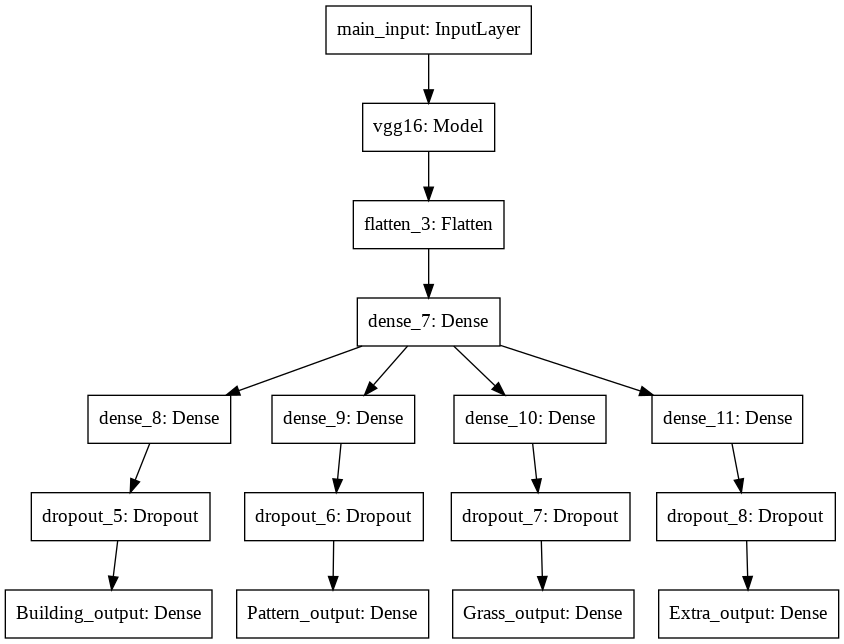

In [ ]:
plot_model(model)

In [ ]:
opt = SGD(lr=1e-5, decay=1e-6, momentum=0.9, clipnorm=1.0)
model.compile(optimizer=opt,
              loss={'Building_output': 'categorical_crossentropy', 
                    'Pattern_output': 'binary_crossentropy',
                    'Grass_output': 'categorical_crossentropy',
                    'Extra_output': 'binary_crossentropy'},
              metrics=["accuracy"]
               )

Train on 3452 samples, validate on 864 samples
Epoch 1/100
3452/3452 [==============================] - 95s 27ms/step - loss: 4.5602 - Building_output_loss: 1.3071 - Pattern_output_loss: 1.3339 - Grass_output_loss: 0.9856 - Extra_output_loss: 0.9336 - Building_output_accuracy: 0.3236 - Pattern_output_accuracy: 0.3707 - Grass_output_accuracy: 0.2717 - Extra_output_accuracy: 0.4906 - val_loss: 3.9341 - val_Building_output_loss: 1.1493 - val_Pattern_output_loss: 1.0176 - val_Grass_output_loss: 0.9164 - val_Extra_output_loss: 0.8508 - val_Building_output_accuracy: 0.2199 - val_Pattern_output_accuracy: 0.3484 - val_Grass_output_accuracy: 0.2407 - val_Extra_output_accuracy: 0.4673
Epoch 2/100
3452/3452 [==============================] - 73s 21ms/step - loss: 4.1314 - Building_output_loss: 1.2751 - Pattern_output_loss: 1.0119 - Grass_output_loss: 0.9349 - Extra_output_loss: 0.9095 - Building_output_accuracy: 0.3265 - Pattern_output_accuracy: 0.4355 - Grass_output_accuracy: 0.2963 - Extra_outp

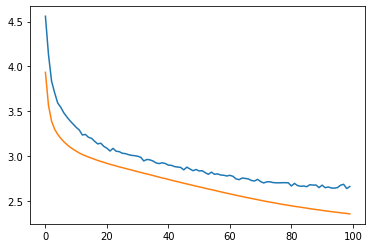

In [ ]:
History= model.fit({'main_input': X_data_train},
            {'Building_output': building_labels,
                    'Pattern_output': Pattern_labels,
                    'Grass_output': Grass_labels,
                    'Extra_output': Extra_labels},
              epochs=100, batch_size=32,
              verbose=1,
              validation_split=0.2,
             )
model.save(models_dir+"K_multitask_trained_VGG_100_new.h5")
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.show()

### Load model & Predict




In [ ]:
model=load_model(models_dir+"K_multitask_trained_VGG_100_new.h5")

In [ ]:
scores =   model.evaluate({'main_input': X_data_test},
            {'Building_output': building_labels_test,
                    'Pattern_output': Pattern_labels_test,
                    'Grass_output': Grass_labels_test,
                    'Extra_output': Extra_labels_test})

762/762 [==============================] - 11s 14ms/step


In [ ]:
print("loss: ",scores[0] ) 
print("Building_output_loss: ",scores[1] ) 
print("Pattern_output_loss: ",scores[2] )  
print("Grass_output_loss: ",scores[3] ) 
print("Extra_output_loss: ",scores[4] ) 
print("Building_output_accuracy: ",scores[5] ) 
print("Pattern_output_accuracy: ",scores[6] ) 
print("Grass_output_accuracy: ",scores[7] )  
print("Extra_output_accuracy: ",scores[8] ) 

loss:  2.3302225371984044
Building_output_loss:  0.581108808517456
Pattern_output_loss:  0.5990616679191589
Grass_output_loss:  0.587806224822998
Extra_output_loss:  0.5607627034187317
Building_output_accuracy:  0.7440944910049438
Pattern_output_accuracy:  0.6811023354530334
Grass_output_accuracy:  0.5669291615486145
Extra_output_accuracy:  0.722769021987915


In [ ]:
pred = model.predict(X_data_test)

In [ ]:
b_prediction =to_categorical(np.argmax(pred[0], axis=1)).astype(int)
b_prediction

array([[0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1]])

In [ ]:
p_prediction =to_categorical(np.argmax(pred[1], axis=1)).astype(int)
p_prediction

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [ ]:
g_prediction =to_categorical(np.argmax(pred[2], axis=1)).astype(int)
g_prediction

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0]])

In [ ]:
e_prediction =(pred[3] >0.5).astype(int)
e_prediction

array([[1, 1, 0, 1],
       [1, 1, 0, 1],
       [1, 1, 0, 1],
       ...,
       [0, 1, 0, 1],
       [0, 1, 0, 0],
       [1, 1, 0, 1]])

In [ ]:
predictions = np.concatenate((b_prediction,p_prediction,g_prediction,e_prediction) , axis =1)
predictions

array([[0, 1, 0, ..., 1, 0, 1],
       [0, 1, 0, ..., 1, 0, 1],
       [0, 0, 1, ..., 1, 0, 1],
       ...,
       [1, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 1]])

In [ ]:
predicted_df = pd.DataFrame(predictions, columns=y_labels) 
predicted_df[x_label]= df_test[x_label].to_list()
ordered_cols=[x_label]+y_labels
predicted_df=predicted_df[ordered_cols]
true_labels = df_test[y_labels].to_numpy()
predicted_df.head()

,ImageName,High Building Density,Moderate Building Density,Low Building Density,Regular Layout,Irregular Layout,Dense Greenery,Sparse Greenery,Very Sparse Greenery,Grass,Trees,Large Buildings,Exposed Soil
0,Peshawar_1-1tile_11400-19200.png,0,1,0,0,1,0,1,0,1,1,0,1
1,Lahore_image_1029.png,0,1,0,0,1,0,1,0,1,1,0,1
2,Peshawar_1-1tile_12400-16000.png,0,0,1,0,1,0,1,0,1,1,0,1
3,Peshawar_1-1tile_14200-20600.png,0,1,0,0,1,0,1,0,1,1,0,1
4,Lahore_image_1744.png,0,0,1,0,1,0,1,0,1,1,0,1


##AHP

In [ ]:
AHP=[4.1, 15.5,6.8,31.9,1.7,2.1,6.0,2.1,4.9,5.9,13.3,5.6]
Planned_Scores = predictions @ AHP
Planned_Scores

array([39.6, 39.6, 30.9, 39.6, 30.9, 30.9, 19.4, 30.9, 39.6, 39.6, 30.9,
       13.8, 30.9, 30.9, 39.6, 27. , 30.9, 30.9, 69.8, 34.7, 30.9, 13.8,
       19.4, 30.9, 39.6, 27. , 69.8, 30.9, 35.7, 39.6, 18.7, 19.4, 30.9,
       39.6, 39.6, 30.9, 30.9, 30.9, 39.6, 30.9, 39.6, 30.9, 30.9, 30.9,
       30.9, 39.6, 39.6, 19.4, 27. , 39.6, 30.9, 27. , 27. , 30.9, 39.6,
       28.2, 39.6, 27. , 13.8, 19.4, 39.6, 39.6, 30.9, 19.4, 30.9, 27. ,
       18.7, 30.9, 39.6, 39.6, 30.9, 39.6, 39.6, 30.9, 39.6, 39.6, 27. ,
       39.6, 30.9, 30.9, 30.9, 27. , 13.8, 25.2, 30.9, 24.3, 39.6, 39.6,
       39.6, 35.7, 30.9, 30.9, 39.6, 30.9, 18.7, 24.3, 30.9, 30.9, 25.3,
       39.6, 30.9, 69.8, 39.6, 24.3, 39.6, 30.9, 39.6, 30.9, 30.9, 30.9,
       30.9, 39.6, 30.9, 24.3, 27. , 30.9, 19.4, 24.3, 30.9, 30.9, 35.7,
       64.2, 30.9, 13.8, 27. , 27. , 39.6, 69.8, 30.9, 30.9, 30.9, 23.3,
       39.6, 13.8, 64.9, 34.7, 27. , 39.6, 69.8, 39.6, 39.6, 30.9, 30.9,
       27. , 61.1, 23.3, 30.9, 39.6, 24.3, 27. , 34

### Example Images and their AHP score

True Labels: 
 ['Moderate Building Density', 'Regular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Large Buildings']

Predicted Labels: 
 ['Moderate Building Density', 'Irregular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Exposed Soil']

Planned Score: 
 39.6


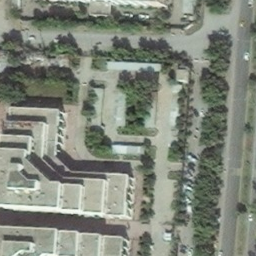

In [ ]:
TestImagesNames=predicted_df['ImageName']
def Show_Image(index):
  #Show TRue Labels
  true_labels = dict(df_test.iloc[index][df_test.iloc[index]==1])
  print("True Labels: \n",list(true_labels.keys()))
  predicted_labels = dict(predicted_df.iloc[index][predicted_df.iloc[index]==1])
  print("\nPredicted Labels: \n",list(predicted_labels.keys()))
  print("\nPlanned Score: \n",Planned_Scores[index])
  #Show Image
  image_dir = '/content/drive/My Drive/DeepLearning/DeepProject_UrbanAnalysis/Final_ProjectData/Data/' + TestImagesNames[index] 
  im = Image.open(image_dir)  
  return im
Show_Image(0)

True Labels: 
 ['Low Building Density', 'Irregular Layout', 'Sparse Greenery', 'Grass', 'Trees']

Predicted Labels: 
 ['Low Building Density', 'Irregular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Exposed Soil']

Planned Score: 
 30.900000000000002


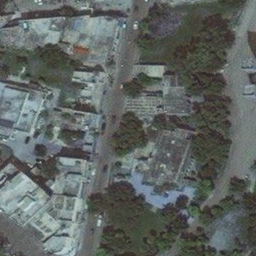

In [ ]:
Show_Image(10)

True Labels: 
 ['Low Building Density', 'Irregular Layout', 'Grass', 'Trees', 'Exposed Soil']

Predicted Labels: 
 ['Low Building Density', 'Irregular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Exposed Soil']

Planned Score: 
 30.900000000000002


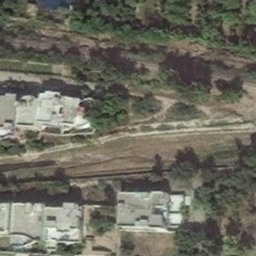

In [ ]:
Show_Image(20)

True Labels: 
 ['High Building Density', 'Regular Layout', 'Very Sparse Greenery', 'Trees', 'Exposed Soil']

Predicted Labels: 
 ['High Building Density', 'Irregular Layout', 'Very Sparse Greenery', 'Grass', 'Trees']

Planned Score: 
 18.7


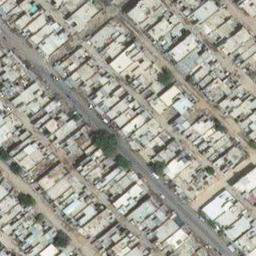

In [ ]:
Show_Image(30)

True Labels: 
 ['Moderate Building Density', 'Irregular Layout', 'Sparse Greenery', 'Trees', 'Exposed Soil']

Predicted Labels: 
 ['Moderate Building Density', 'Irregular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Exposed Soil']

Planned Score: 
 39.6


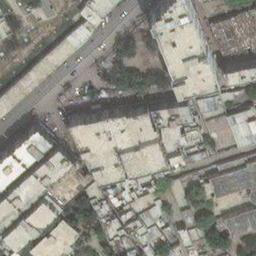

In [ ]:
Show_Image(40)

True Labels: 
 ['High Building Density', 'Irregular Layout']

Predicted Labels: 
 ['Low Building Density', 'Irregular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Exposed Soil']

Planned Score: 
 30.900000000000002


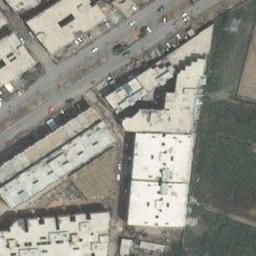

In [ ]:
Show_Image(50)

True Labels: 
 ['Moderate Building Density', 'Irregular Layout', 'Trees', 'Large Buildings', 'Exposed Soil']

Predicted Labels: 
 ['Moderate Building Density', 'Irregular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Exposed Soil']

Planned Score: 
 39.6


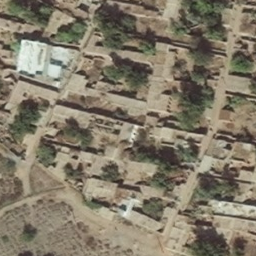

In [ ]:
Show_Image(60)

True Labels: 
 ['Low Building Density', 'Irregular Layout', 'Dense Greenery', 'Grass', 'Trees', 'Exposed Soil']

Predicted Labels: 
 ['Low Building Density', 'Irregular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Exposed Soil']

Planned Score: 
 30.900000000000002


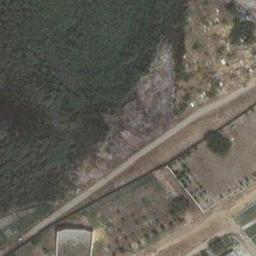

In [ ]:
Show_Image(70)

True Labels: 
 ['Low Building Density', 'Regular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Exposed Soil']

Predicted Labels: 
 ['Low Building Density', 'Irregular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Exposed Soil']

Planned Score: 
 30.900000000000002


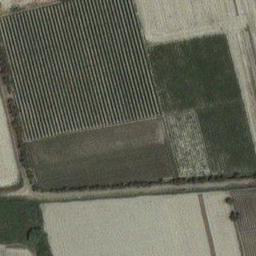

In [ ]:
Show_Image(80)

True Labels: 
 ['Low Building Density', 'Regular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Exposed Soil']

Predicted Labels: 
 ['Low Building Density', 'Irregular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Exposed Soil']

Planned Score: 
 30.900000000000002


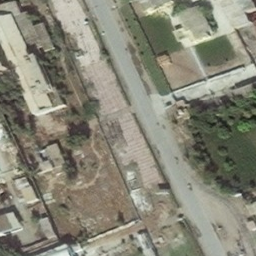

In [ ]:
Show_Image(90)

True Labels: 
 ['Low Building Density', 'Regular Layout', 'Dense Greenery', 'Grass', 'Trees', 'Large Buildings', 'Exposed Soil']

Predicted Labels: 
 ['Low Building Density', 'Irregular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Exposed Soil']

Planned Score: 
 30.900000000000002


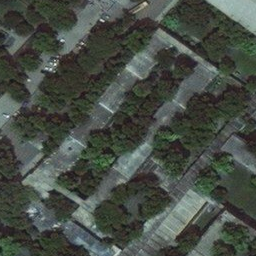

In [ ]:
Show_Image(100)

True Labels: 
 ['High Building Density', 'Irregular Layout', 'Very Sparse Greenery', 'Trees']

Predicted Labels: 
 ['High Building Density', 'Irregular Layout', 'Very Sparse Greenery', 'Trees']

Planned Score: 
 13.8


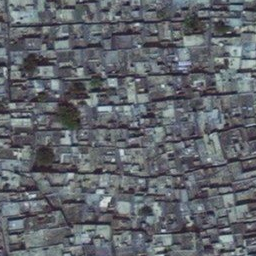

In [ ]:
Show_Image(750)

True Labels: 
 ['Moderate Building Density', 'Regular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Exposed Soil']

Predicted Labels: 
 ['Moderate Building Density', 'Regular Layout', 'Sparse Greenery', 'Trees', 'Exposed Soil']

Planned Score: 
 64.9


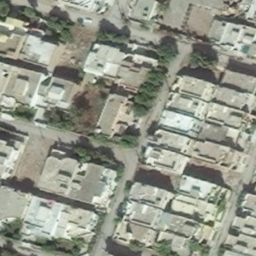

In [ ]:
Show_Image(752)

True Labels: 
 ['Moderate Building Density', 'Regular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Large Buildings', 'Exposed Soil']

Predicted Labels: 
 ['Moderate Building Density', 'Irregular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Exposed Soil']

Planned Score: 
 39.6


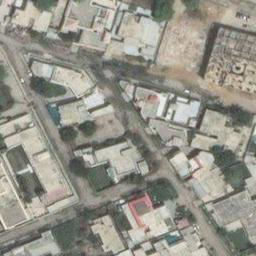

In [ ]:
Show_Image(753)

True Labels: 
 ['Low Building Density', 'Irregular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Large Buildings', 'Exposed Soil']

Predicted Labels: 
 ['Low Building Density', 'Irregular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Exposed Soil']

Planned Score: 
 30.900000000000002


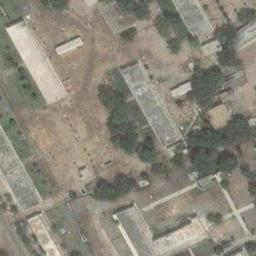

In [ ]:
Show_Image(754)

True Labels: 
 ['Low Building Density', 'Irregular Layout', 'Dense Greenery', 'Grass', 'Trees', 'Exposed Soil']

Predicted Labels: 
 ['Low Building Density', 'Irregular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Exposed Soil']

Planned Score: 
 30.900000000000002


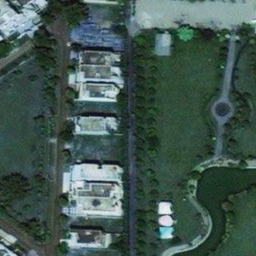

In [ ]:
Show_Image(755)

True Labels: 
 ['Moderate Building Density', 'Regular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Exposed Soil']

Predicted Labels: 
 ['Moderate Building Density', 'Irregular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Exposed Soil']

Planned Score: 
 39.6


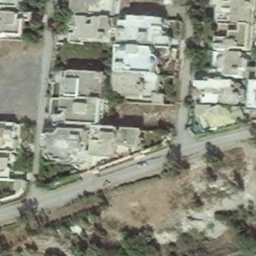

In [ ]:
Show_Image(757)

True Labels: 
 ['Low Building Density', 'Regular Layout', 'Grass', 'Trees', 'Exposed Soil']

Predicted Labels: 
 ['Low Building Density', 'Irregular Layout', 'Sparse Greenery', 'Grass', 'Trees', 'Exposed Soil']

Planned Score: 
 30.900000000000002


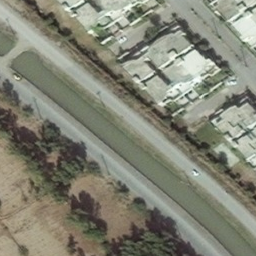

In [ ]:
Show_Image(758)

True Labels: 
 ['Moderate Building Density', 'Regular Layout', 'Sparse Greenery', 'Trees']

Predicted Labels: 
 ['High Building Density', 'Irregular Layout', 'Sparse Greenery', 'Trees', 'Exposed Soil']

Planned Score: 
 23.3


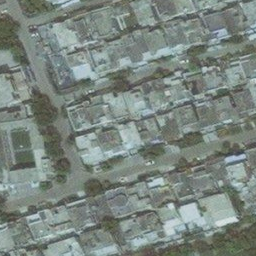

In [ ]:
Show_Image(759)

True Labels: 
 ['High Building Density', 'Regular Layout', 'Trees']

Predicted Labels: 
 ['High Building Density', 'Irregular Layout', 'Very Sparse Greenery', 'Trees']

Planned Score: 
 13.8


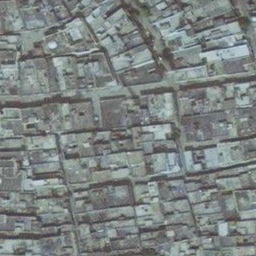

In [ ]:
Show_Image(760)

True Labels: 
 ['Low Building Density', 'Irregular Layout', 'Very Sparse Greenery', 'Trees', 'Exposed Soil']

Predicted Labels: 
 ['Low Building Density', 'Irregular Layout', 'Dense Greenery', 'Grass', 'Trees', 'Exposed Soil']

Planned Score: 
 27.0


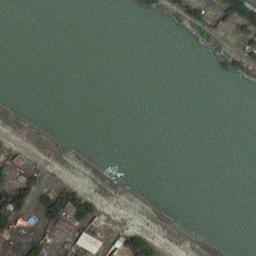

In [ ]:
Show_Image(761)

#Improving Model - Next 50 epochs 

In [ ]:
model=load_model(models_dir+"K_multitask_trained_VGG_100_new.h5")

opt = SGD(lr=1e-5, decay=1e-6, momentum=0.9, clipnorm=1.0)
model.compile(optimizer=opt,
              loss={'Building_output': 'categorical_crossentropy', 
                    'Pattern_output': 'binary_crossentropy',
                    'Grass_output': 'categorical_crossentropy',
                    'Extra_output': 'binary_crossentropy'},
              metrics=["accuracy"]
               )

In [ ]:
History = model.fit({'main_input': X_data_train},
            {'Building_output': building_labels,
                    'Pattern_output': Pattern_labels,
                    'Grass_output': Grass_labels,
                    'Extra_output': Extra_labels},
              epochs=50, batch_size=32,
              verbose=1,
              validation_split=0.2,
             )
model.save(models_dir+"K_multitask_trained_VGG_150_new.h5")

Train on 3452 samples, validate on 864 samples
Epoch 1/50
3452/3452 [==============================] - 40s 12ms/step - loss: 2.6659 - Building_output_loss: 0.6152 - Pattern_output_loss: 0.6130 - Grass_output_loss: 0.8460 - Extra_output_loss: 0.5917 - Building_output_accuracy: 0.7326 - Pattern_output_accuracy: 0.6719 - Grass_output_accuracy: 0.4502 - Extra_output_accuracy: 0.6966 - val_loss: 2.3511 - val_Building_output_loss: 0.5563 - val_Pattern_output_loss: 0.5989 - val_Grass_output_loss: 0.6311 - val_Extra_output_loss: 0.5648 - val_Building_output_accuracy: 0.7674 - val_Pattern_output_accuracy: 0.6794 - val_Grass_output_accuracy: 0.5729 - val_Extra_output_accuracy: 0.7234
Epoch 2/50
3452/3452 [==============================] - 36s 10ms/step - loss: 2.6495 - Building_output_loss: 0.6135 - Pattern_output_loss: 0.6192 - Grass_output_loss: 0.8213 - Extra_output_loss: 0.5951 - Building_output_accuracy: 0.7289 - Pattern_output_accuracy: 0.6702 - Grass_output_accuracy: 0.4594 - Extra_output

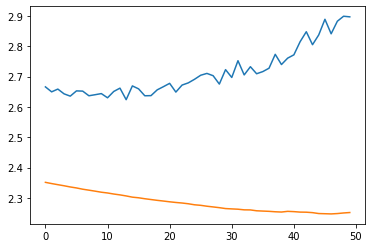

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.show()

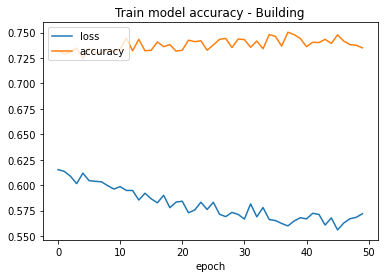

In [ ]:
plt.plot(History.history['Building_output_loss'] )
plt.plot(History.history['Building_output_accuracy'])
plt.title('Train model accuracy - Building')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

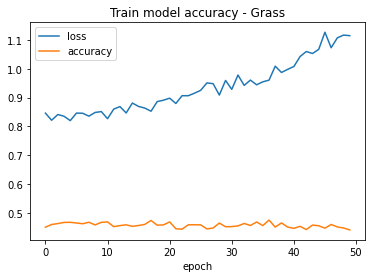

In [ ]:
plt.plot(History.history['Grass_output_loss'] )
plt.plot(History.history['Grass_output_accuracy'])
plt.title('Train model accuracy - Grass')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

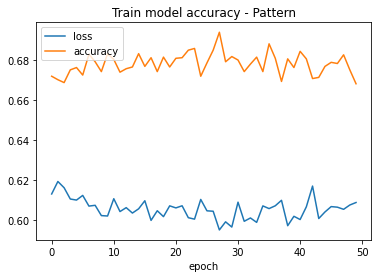

In [ ]:
plt.plot(History.history['Pattern_output_loss'] )
plt.plot(History.history['Pattern_output_accuracy'])
plt.title('Train model accuracy - Pattern')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

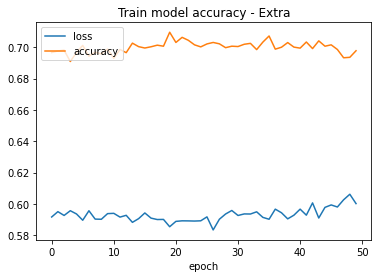

In [ ]:
plt.plot(History.history['Extra_output_loss'] )
plt.plot(History.history['Extra_output_accuracy'])
plt.title('Train model accuracy - Extra')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

In [ ]:
scores =   model.evaluate({'main_input': X_data_test},
            {'Building_output': building_labels_test,
                    'Pattern_output': Pattern_labels_test,
                    'Grass_output': Grass_labels_test,
                    'Extra_output': Extra_labels_test})
print("loss: ",scores[0] ) 
print("Building_output_loss: ",scores[1] ) 
print("Pattern_output_loss: ",scores[2] )  
print("Grass_output_loss: ",scores[3] ) 
print("Extra_output_loss: ",scores[4] ) 
print("Building_output_accuracy: ",scores[5] ) 
print("Pattern_output_accuracy: ",scores[6] ) 
print("Grass_output_accuracy: ",scores[7] )  
print("Extra_output_accuracy: ",scores[8] ) 

762/762 [==============================] - 3s 4ms/step
loss:  2.2361284428694117
Building_output_loss:  0.5228737592697144
Pattern_output_loss:  0.5840721130371094
Grass_output_loss:  0.5739233493804932
Extra_output_loss:  0.5529975295066833
Building_output_accuracy:  0.76115483045578
Pattern_output_accuracy:  0.6955380439758301
Grass_output_accuracy:  0.5721784830093384
Extra_output_accuracy:  0.7332677245140076
